#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Стационарность-ряда" data-toc-modified-id="Стационарность-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Стационарность ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0)

In [3]:
data.sort_index(inplace=True)

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

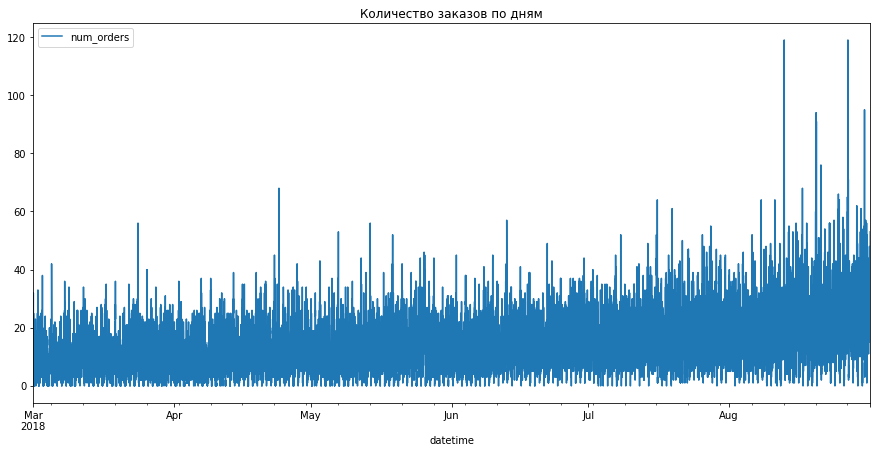

In [6]:
data.plot(figsize=(15,7))
plt.title('Количество заказов по дням')
plt.legend();

In [7]:
df = data.resample('1H').sum()

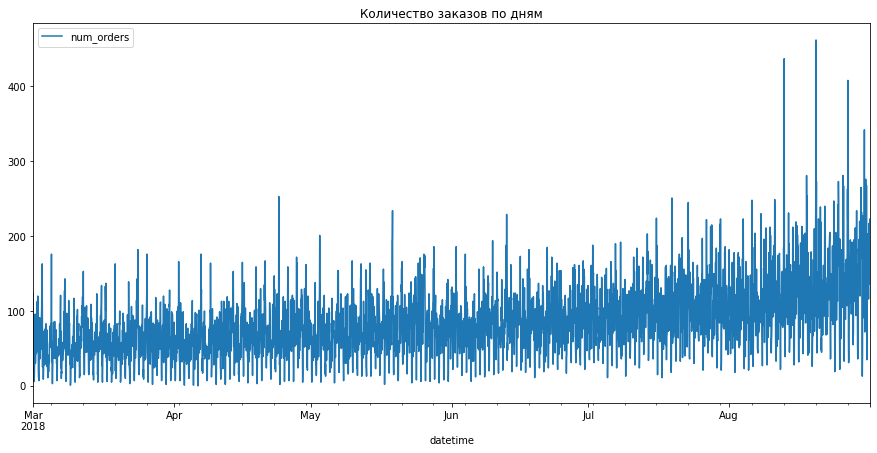

In [8]:
df.plot(figsize=(15,7))
plt.title('Количество заказов по дням')
plt.legend();

In [9]:
decomposed = seasonal_decompose(df)

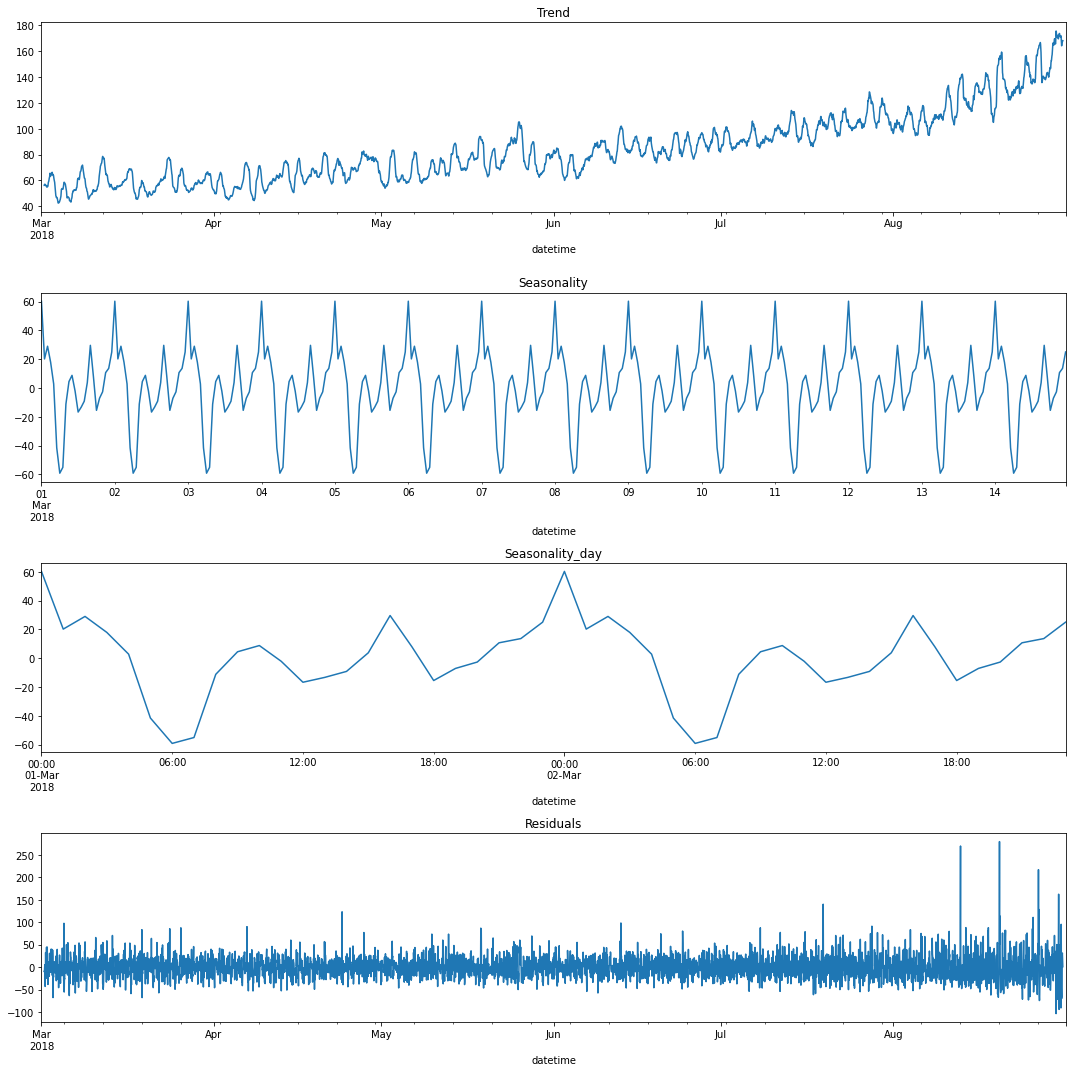

In [10]:
plt.figure(figsize=(15,15))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(412)
decomposed.seasonal['2018-03-01':'2018-03-14'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(413)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality_day')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

По данным графикам можно сделать вывод, что присутствует сезонность и восходящий тренд. Такси реже заказывают в 6 утра, а пик заказов приходится на полночь.

### Стационарность ряда

Проверим ряд на стационарность

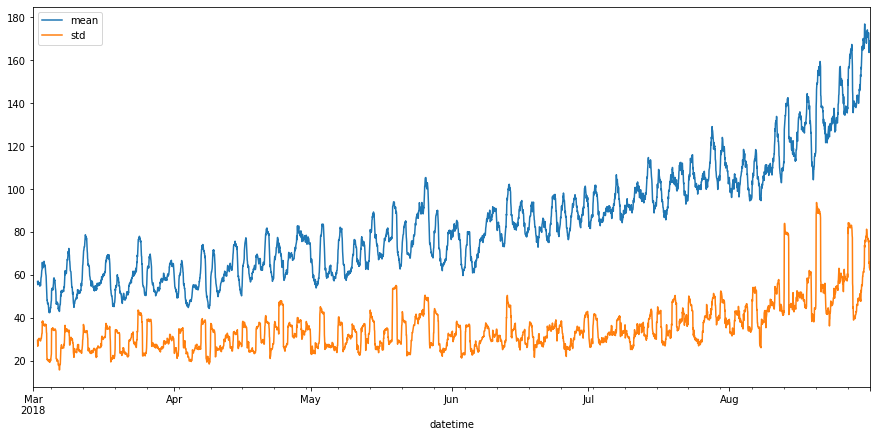

In [11]:
#Построим график средней и СКО
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df[['mean', 'std']].plot(figsize=(15,7));

Ряд не стационарный у него меняется среднее значение и стандартное отклонение. Для прогнозирования нужно будет его привести к стационарному виду.

In [12]:
df=df.drop(['mean', 'std'],axis=1)

## Обучение

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
        
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df.dropna(inplace=True)


In [14]:
make_features(df, 168, 168)

In [15]:
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,0,94.0,127.0,108.0,76.0,50.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,54.226190
2018-03-08 01:00:00,78,3,8,3,1,143.0,94.0,127.0,108.0,76.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.339286
2018-03-08 02:00:00,65,3,8,3,2,78.0,143.0,94.0,127.0,108.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,54.297619
2018-03-08 03:00:00,68,3,8,3,3,65.0,78.0,143.0,94.0,127.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,54.261905
2018-03-08 04:00:00,60,3,8,3,4,68.0,65.0,78.0,143.0,94.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,54.273810


In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)

features = train.drop('num_orders',axis=1)
target = train['num_orders']

features_test = test.drop('num_orders',axis=1)
target_test = test['num_orders']

### Линейная регрессия

In [17]:
%%time
model_line = LinearRegression()
cross_val_line = cross_val_score(model_line,
                                 features,
                                 target,
                                 scoring='neg_mean_squared_error',
                                 n_jobs=-1,
                                 cv=TimeSeriesSplit(n_splits=5))

model_line.fit(features, target)
print('rmse =', np.mean(np.sqrt(np.abs(cross_val_line)))) 

rmse = 22.73293269988398
CPU times: user 913 ms, sys: 1.43 s, total: 2.35 s
Wall time: 2.92 s


### Случайный лес

In [18]:
%%time
parametrs = {"max_depth": [2,10],
             "n_estimators":[10,100,10]}

grid_model_forest = GridSearchCV(RandomForestRegressor(random_state=12345),
                                 parametrs,
                                 scoring='neg_mean_squared_error',
                                 cv = TimeSeriesSplit(n_splits=3),
                                 n_jobs=-1)

grid_model_forest.fit(features, target)

params_forest = grid_model_forest.best_params_
random_forest = RandomForestRegressor(**params_forest, random_state = 12345)

rmse_model_random_forest = np.mean(np.sqrt(np.abs(grid_model_forest.best_score_)))
print('Параметры модели: ', grid_model_forest.best_params_)
print('rmse =', rmse_model_random_forest)

Параметры модели:  {'max_depth': 10, 'n_estimators': 100}
rmse = 24.092768042433672
CPU times: user 1min 27s, sys: 212 ms, total: 1min 27s
Wall time: 3min 4s


### CatBoostRegressor

In [19]:
%%time
params_cat = {
    'max_depth' : range(2, 11, 2)
}

grid_model_cat = GridSearchCV(estimator=CatBoostRegressor(loss_function='RMSE', iterations=700, random_state = 12345), 
                              param_grid=params_cat,
                              verbose=100,
                              scoring='neg_mean_squared_error',
                              cv=TimeSeriesSplit(n_splits=3),
                              n_jobs=-1)

grid_model_cat.fit(features, target, verbose=100)

params_cat = grid_model_cat.best_params_

cat = CatBoostRegressor(**params_cat, loss_function='RMSE', iterations=700, random_state = 12345)

rmse_model_cat = np.mean(np.sqrt(np.abs(grid_model_cat.best_score_)))

print('rmse =', rmse_model_cat)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START max_depth=2.................................................
Learning rate set to 0.054346
0:	learn: 28.8928990	total: 51.9ms	remaining: 36.3s
100:	learn: 16.2918085	total: 878ms	remaining: 5.21s
200:	learn: 14.7235807	total: 1.6s	remaining: 3.98s
300:	learn: 13.5450842	total: 2.29s	remaining: 3.04s
400:	learn: 12.6123949	total: 3.14s	remaining: 2.34s
500:	learn: 11.8316885	total: 3.78s	remaining: 1.5s
600:	learn: 11.1727507	total: 4.7s	remaining: 775ms
699:	learn: 10.6233327	total: 5.45s	remaining: 0us
[CV 1/3; 1/5] END ...............................max_depth=2; total time=   8.1s
[CV 2/3; 1/5] START max_depth=2.................................................
Learning rate set to 0.060621
0:	learn: 32.1287515	total: 6.97ms	remaining: 4.88s
100:	learn: 17.8064851	total: 1.09s	remaining: 6.5s
200:	learn: 16.4777944	total: 2.18s	remaining: 5.41s
300:	learn: 15.6808002	total: 3.2s	remaining: 4.25s
400:	learn

In [20]:
df_result=pd.DataFrame(np.array([np.mean(np.sqrt(np.abs(cross_val_line))),
                                 rmse_model_random_forest,
                                 rmse_model_cat]),
                       index=['Linear_Regression','Random_Forest_Regressor','Cat_Boost_Regressor'])
df_result.set_axis(['rmse'],axis='columns',inplace=True)
df_result

,rmse
Linear_Regression,22.732933
Random_Forest_Regressor,24.092768
Cat_Boost_Regressor,23.953170


Лучшие результаты RMSE на валидационной выборке получились на модели Linear_Regression.

## Тестирование

In [21]:
# Линейная модель
predict_line = model_line.predict(features_test)
rmse_line = mean_squared_error(target_test, predict_line, squared=False)

In [22]:
rmse_line

35.36268291192508

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_orders'>

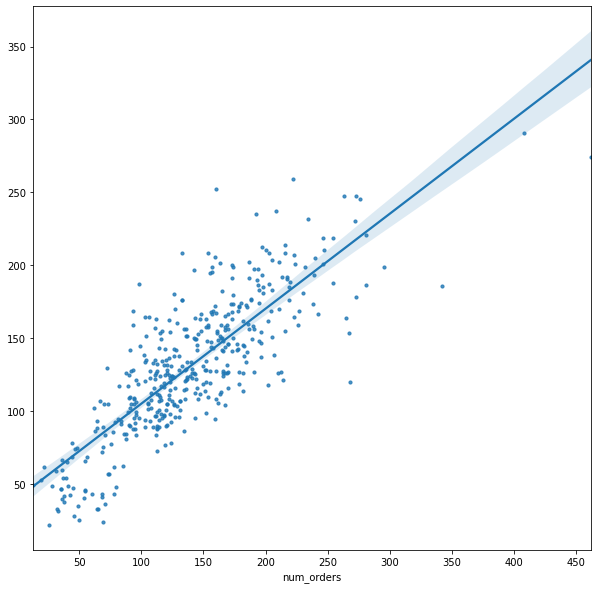

In [23]:
plt.figure( figsize= (10 , 10 )) 
sns.regplot(target_test,  model_line.predict(features_test), scatter_kws= {"s":  10 }) 

In [24]:
pred_previous = test['num_orders'].shift(fill_value=train.iloc[-1][0])
rmse_previous = mean_squared_error(test['num_orders'], pred_previous, squared=False)

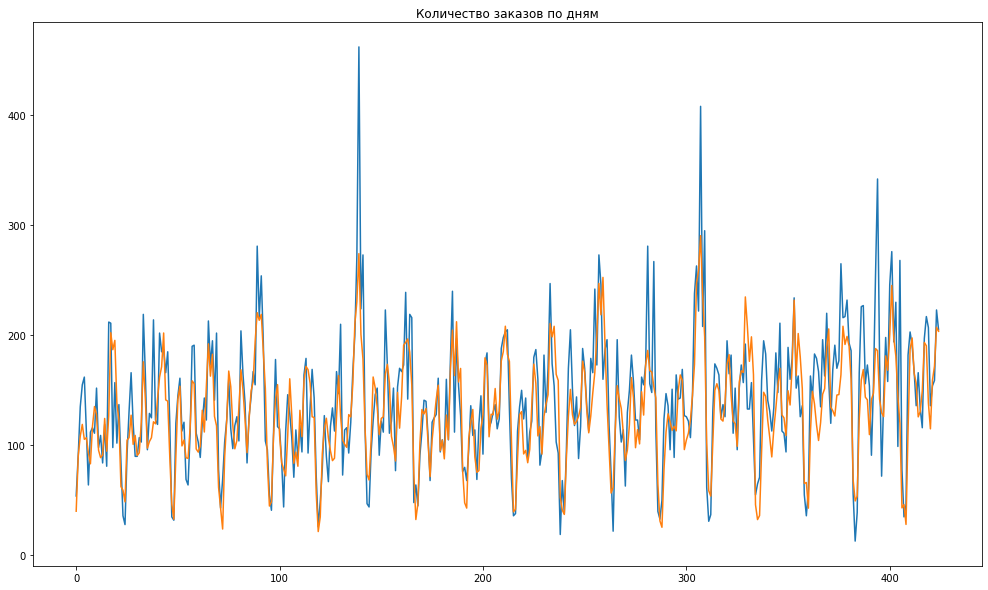

In [25]:
plt.title('Количество заказов по дням')
pd.Series(target_test.values).plot(figsize=(17,10));
plt.plot(predict_line);

**Вывод**

Проведен анализ и подготовлены данные для обучения моделей. Путем проверки моделей на тестовых выборках, определено, что модель Linear_Regressio имеет лучшие показатели по RMSE.